In [1]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'unsupervised'
seed = 44

In [2]:
import autograd.numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

[Errno 17] File exists: '/Users/fultonw/Documents/projects/runs/domain_adapt_run/cache/supervised_weighted_least_squares'


In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats, scipy
import cvxopt
import domain_adapt.domain_adapt.kernels as kernels
import pymanopt
import pprint, autograd
import scipy.optimize
import domain_adapt.domain_adapt.SDR_data as SDR_data
import domain_adapt.domain_adapt.SDR_constructor as SDR_constructor
import sklearn
from sklearn import grid_search, linear_model, pipeline
from sklearn.metrics import roc_curve, auc

Couldn't import dot_parser, loading of dot files will not be possible.


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
# get data
import data.readmissions.readmissions.fxns as readmissions_data
num_source = 500
num_target = 500
source_data = readmissions_data.bwh_orig_data()
source_data = source_data.reindex(np.random.permutation(source_data.index))
target_data = readmissions_data.mgh_data()
target_data = target_data.reindex(np.random.permutation(target_data.index))
source_X_df = pd.concat((source_data.iloc[0:num_source,0:-1], pd.DataFrame({'bias':np.ones(num_source)},index=source_data.index[0:num_source])),axis=1, join='inner')
target_X_df = pd.concat((target_data.iloc[0:num_target,0:-1], pd.DataFrame({'bias':np.ones(num_target)},index=target_data.index[0:num_target])),axis=1, join='inner')
feature_names = source_X_df.columns
source_X = source_X_df.values
target_X = target_X_df.values
source_y = source_data.iloc[0:num_source,-1].values
target_y = target_data.iloc[0:num_target,-1].values
print source_X.shape, source_y.shape
feature_names = source_X_df.columns
shift_X, shift_y = kernels.matrices_to_shift_Xy(source_X, target_X, source_y, target_y)

(500, 38) (500,)


In [5]:
print source_X_df.shape, source_X_df.columns.shape
feature_names.shape

(500, 38) (38,)


(38,)

In [6]:
# constants not cross validated
num_trials = 1
num_anneals = 1
B_max = 10
KMM_eps = 0.001
desired_dim = 5
lin_solver = lambda A,b: scipy.sparse.linalg.lsmr(A,b)[0]
cvxopt_solver = kernels.cvxopt_solver
get_KMM_get_K = lambda P,step, xs_train, xs_test: functools.partial(kernels.get_gaussian_K, 1.*kernels.median_distance(np.dot(np.vstack((xs_train,xs_test)),P),np.dot(np.vstack((xs_train,xs_test)),P)))
get_SDR_get_K = lambda P,step, xs1, xs2: lambda xs1, xs2: xs1
get_SDR_get_Ky = lambda P,step, ys1, ys2: lambda ys1, ys2: ys1
get_weight_estimator_get_K = lambda us_train, us_test: functools.partial(kernels.get_gaussian_K, kernels.median_distance(us_train, us_test))
weight_estimator = lambda us_train, us_test: kernels.get_KMM_ws(B_max, KMM_eps, get_weight_estimator_get_K(us_train,us_test), us_train, us_test)
def downstream_estimator_scorer(estimator, shift_X, shift_y, fit_params):
    source_X, target_X, source_y, target_y, source_ws = kernels.shift_Xy_to_matrices(shift_X, shift_y, weights=True)
    return kernels.logloss(source_y, estimator.source_predict(shift_X), source_ws)
downstream_estimator_params = {'C':np.exp2([-2,0,2,4,6])}
downstream_estimator = grid_search.GridSearchCV(kernels.shiftLogisticRegression(fit_intercept=False), param_grid=downstream_estimator_params, cv=2, scoring=downstream_estimator_scorer)

In [7]:
#
#regs = [0.1,1.,5.,10.,25.]
regs = [1.]
#tradeoffs = [0.1,1.,10]
tradeoffs = [0.0001]

In [8]:
#
def get_pipeline_param(reg, tradeoff):
    obj_from_wsopt_and_Ks, dobj_dwsopt, get_dobj_dP_thru_Ku = SDR_constructor.get_logreg_obj_and_gradients(lin_solver, cvxopt_solver, tradeoff, reg)
    horse = functools.partial(SDR_constructor.get_noplot_SDR_horse, desired_dim, num_trials, num_anneals, lin_solver, cvxopt_solver, B_max, KMM_eps, get_KMM_get_K, get_SDR_get_K, get_SDR_get_Ky, obj_from_wsopt_and_Ks, dobj_dwsopt, get_dobj_dP_thru_Ku)
    return {'projection_estimator__horse':[horse],'weighted_estimator__downstream_estimator':[downstream_estimator],'weighted_estimator__weight_estimator':[weight_estimator]}

In [9]:
# 
cv_base_estimator = pipeline.Pipeline([('projection_estimator',kernels.projection_estimator(feature_names=feature_names)),('weighted_estimator',kernels.weighted_estimator())])
cv_estimator_params = [get_pipeline_param(reg, tradeoff) for tradeoff in tradeoffs for reg in regs]
use_frac = 0.05
def shift_scorer(loss, estimator, shift_X, shift_y):
    use_shift_X = shift_X[0:int(use_frac*len(shift_X))]
    use_shift_y = shift_y[0:int(use_frac*len(shift_y))]
    ys_hat = estimator.predict(use_shift_X) # assumes estimator predicts target, not source
    source_X, target_X, source_y, target_y = kernels.shift_Xy_to_matrices(use_shift_X, use_shift_y)
    return loss(target_y, ys_hat) 
estimator_scorer = functools.partial(shift_scorer, kernels.logloss)
cv_estimator = grid_search.GridSearchCV(cv_base_estimator, param_grid=cv_estimator_params, cv=2, scoring=estimator_scorer)

cv 0
v_0
bias                       0.417770
Jail                       0.297981
FallRisk                   0.273384
PositiveSocialSituation   -0.256406
PoorSocialSupport          0.232865
PoorHousing               -0.230644
NegativeIdeation           0.213992
CMP                        0.204515
PoorMentalStatus          -0.201312
DomesticAbuse             -0.184273
dtype: float64
v_1
PoorHealthLiteracy        0.414501
ClinicalTroubles         -0.310134
PoorMentalStatus          0.298673
MoodProblems              0.293059
NegativeIdeation         -0.280916
Pain                     -0.264970
SchedulingDifficulties    0.245170
FinancialProblems         0.199954
bias                      0.183470
PoorSocialSupport         0.173688
dtype: float64
v_2
Jail                          0.374085
AtRisk                        0.338712
TransportationDifficulties    0.329150
ClinicalTroubles             -0.260564
CMP                          -0.260482
PoorPhysical                 -0.260208
PositiveC

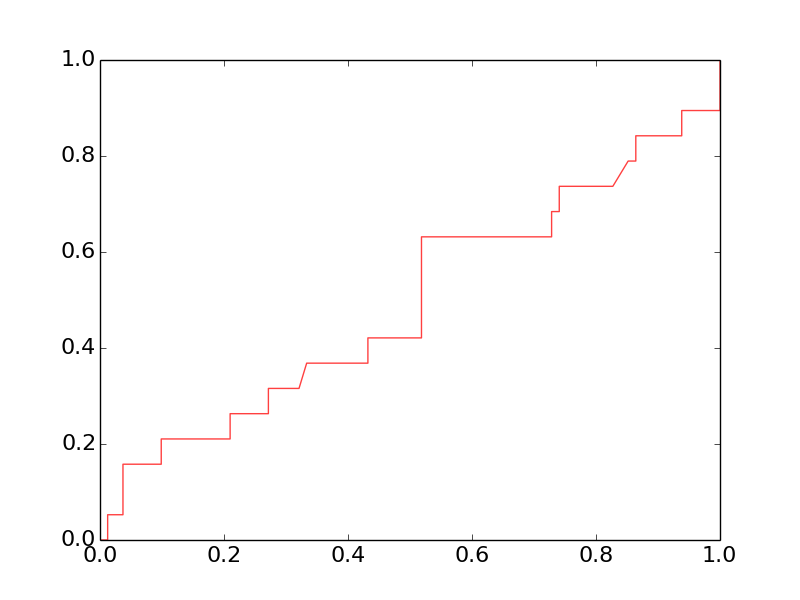

cv 1
v_0
PositivePhysical     -0.545305
PoorHealthLiteracy    0.344160
SubstanceAbuse       -0.289451
PoorMentalStatus     -0.262744
Pain                  0.239274
PoorCompetency       -0.200897
Jail                  0.178158
FeelsUnsafe          -0.172115
FinancialProblems    -0.170930
NegativeIdeation     -0.159674
dtype: float64
v_1
SubstanceAbuse            -0.409523
PoorMentalStatus          -0.303964
Jail                      -0.274493
FallRisk                   0.268457
PoorPhysical              -0.260002
PositiveSocialSituation   -0.239944
MaxCare                    0.221184
PositivePhysical           0.214765
PoorCompetency             0.214645
NeedsMovementAssist       -0.214220
dtype: float64
v_2
DifficultBehavior            -0.344066
PoorSocialSupport             0.326190
PositiveCognitiveIssues      -0.313617
PositiveSocialSituation      -0.312642
ProblemsFollowingMeds         0.286207
FallRisk                     -0.230906
Noshow                       -0.219687
Transporta

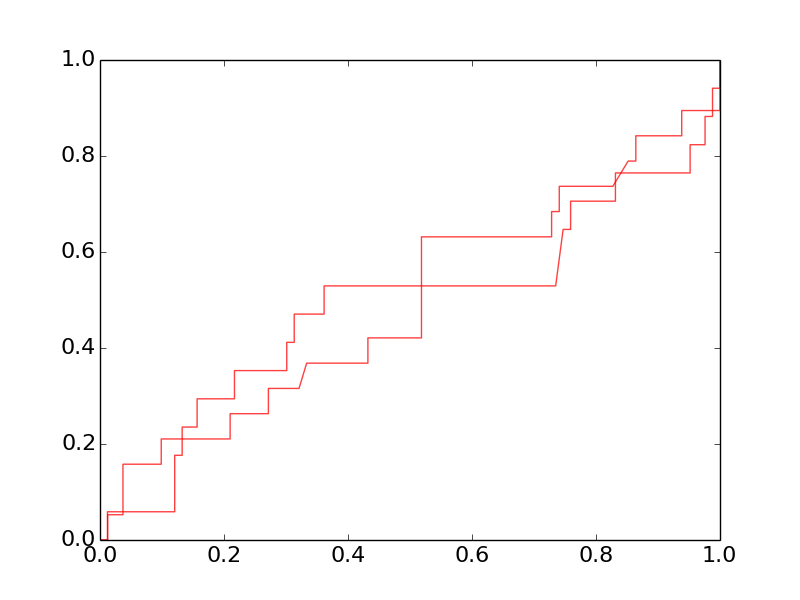

cv 2
v_0
Jail                 -0.401868
bias                 -0.300141
PoorCompetency        0.273768
ClinicalTroubles      0.273360
AtRisk                0.271810
PoorHealthLiteracy   -0.263535
PoorADLs             -0.254656
CMP                  -0.206670
Noshow                0.203258
SubstanceAbuse       -0.189757
dtype: float64
v_1
ClinicalTroubles               0.385391
PoorSocialSupport              0.331336
bias                           0.309798
HistoryofMultipleAdmissions   -0.308130
TransportationDifficulties    -0.287004
PoorMentalStatus               0.258952
PoorHousing                   -0.249287
Jail                           0.207137
ProblemsFollowingMeds          0.189851
Pain                           0.182378
dtype: float64
v_2
SubstanceAbuse           -0.389306
PoorCondition            -0.386803
NeedsMovementAssist      -0.325546
PoorADLs                  0.298178
AtRisk                   -0.276640
SchedulingDifficulties    0.222024
PoorPrognosis            -0.18502

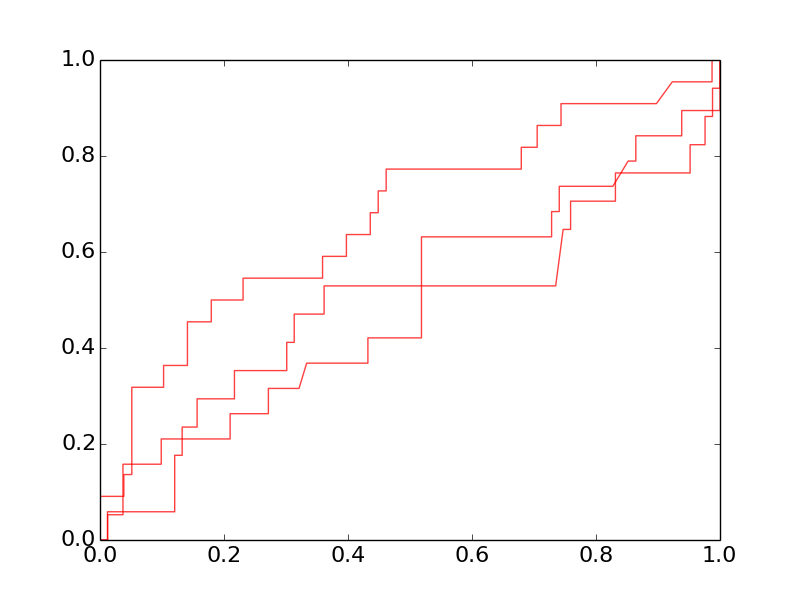

cv 3
v_0
ProblemsFollowingMeds        -0.404973
SchedulingDifficulties       -0.318462
PoorCompetency               -0.256722
FallRisk                     -0.256202
NeedsMovementAssist          -0.221737
SubstanceAbuse                0.216993
TransportationDifficulties    0.216904
PoorMentalStatus             -0.210750
PositivePhysical             -0.207545
CMP                          -0.206262
dtype: float64
v_1
FeelsUnsafe               -0.526148
CMP                       -0.289878
PoorHealthLiteracy         0.281401
NegativeIdeation           0.256154
PositiveSocialSituation    0.247356
AtRisk                     0.243271
Noshow                     0.226821
bias                       0.193219
DifficultBehavior          0.178922
PoorCondition              0.178136
dtype: float64
v_2
NonCompliance                -0.388405
bias                          0.350131
CMP                          -0.345441
DifficultBehavior            -0.289819
SchedulingDifficulties        0.259426
Transpor

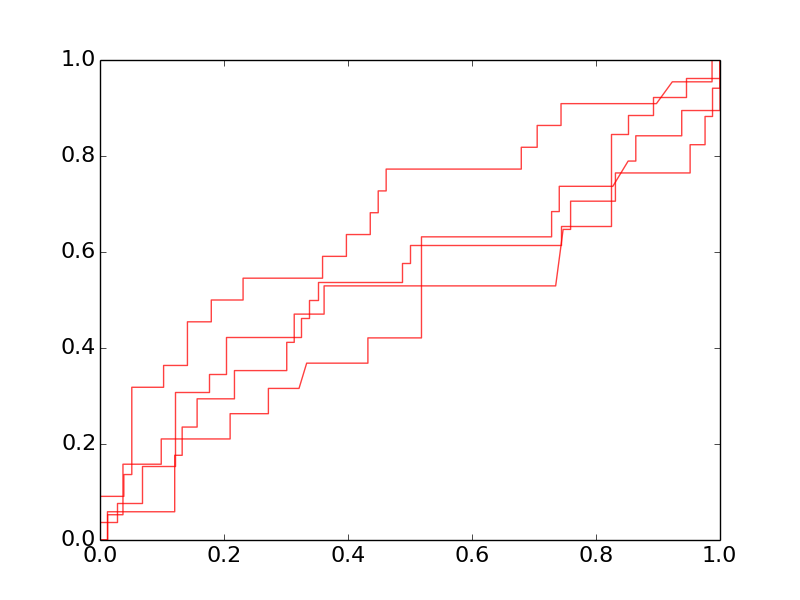

cv 4
v_0
Noshow                -0.441170
NeedsMovementAssist   -0.308253
Pain                  -0.296369
PoorADLs              -0.283041
StateCare             -0.247446
NonCompliance          0.236239
AtRisk                -0.207532
PoorHealthLiteracy     0.203105
PositivePhysical      -0.177964
FeelsUnsafe           -0.165091
dtype: float64
v_1
ProblemsFollowingMeds    0.331769
PositivePhysical         0.320770
FallRisk                 0.317702
StateCare               -0.315270
PoorHousing              0.303865
AtRisk                   0.268639
DifficultBehavior       -0.217667
CMP                     -0.202797
NonCompliance           -0.198925
NoHealthCarePlanning    -0.196855
dtype: float64
v_2
PoorSocialSupport              0.397676
PositiveSocialSituation       -0.396719
PoorHousing                    0.298238
HistoryofMultipleAdmissions   -0.289648
StateCare                      0.255649
MaxCare                        0.209443
Noshow                        -0.206377
NegativeIdeat

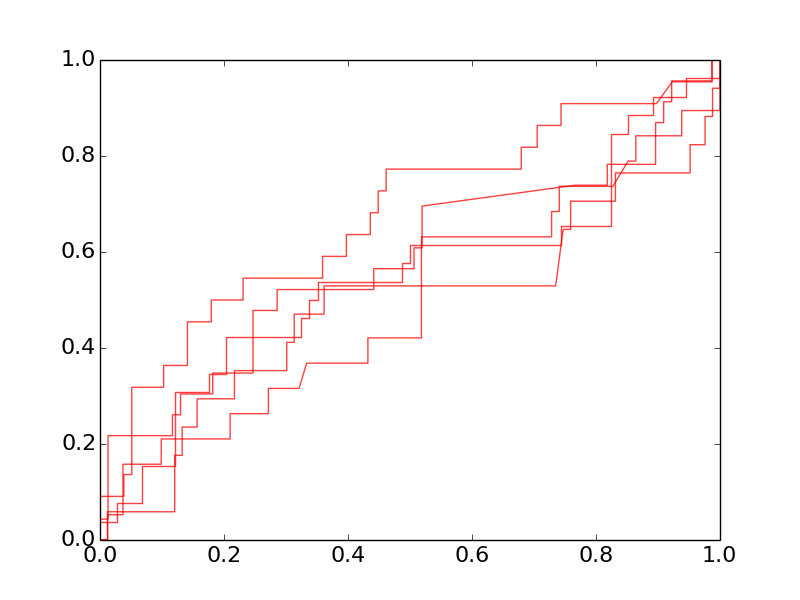

0    0.494152
1    0.486889
2    0.674242
3    0.546778
4    0.584133
dtype: float64 mean: 0.557238801449 std: 0.0684860107794


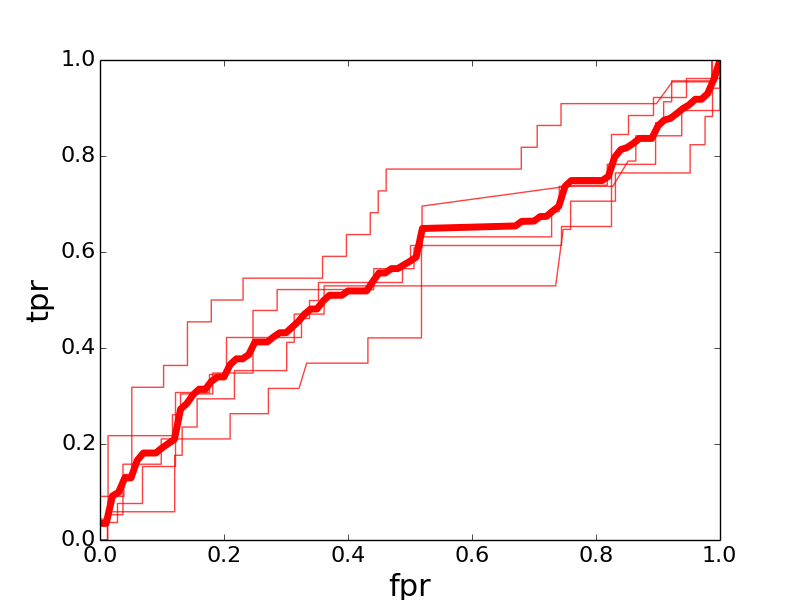

In [10]:
from scipy import interp
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
fpr_points = np.linspace(0.,1.,101)
roc_curves = []
auc_vals = []
color = 'r'
label = 'asdf'
from sklearn.cross_validation import KFold
outer_cv = sklearn.cross_validation.KFold(num_source, 5)
for (i,(train, test)) in enumerate(reversed(list(outer_cv))):
    print 'cv', i
    shift_X_train, shift_y_train = [shift_X[idx] for idx in train], [shift_y[idx] for idx in train]
    shift_X_test, shift_y_test = [shift_X[idx] for idx in test], [shift_y[idx] for idx in test]
    cv_estimator.fit(shift_X_train, shift_y_train)
    target_y_test_hat = cv_estimator.predict(shift_X_test)
    source_X_test, target_X_test, source_y_test, target_y_test = kernels.shift_Xy_to_matrices(shift_X_test, shift_y_test)
    fpr, tpr, thresholds = roc_curve(target_y_test, target_y_test_hat)
    auc_vals.append(auc(fpr,tpr))
    roc_curves.append(interp(fpr_points, fpr, tpr))
    ax.plot(fpr, tpr, color = color, alpha=0.75, zorder=np.random.random())
    basic.display_fig_inline(fig)
roc_curves_df = pd.DataFrame(roc_curves, columns=fpr_points)
ax.plot(fpr_points, roc_curves_df.mean(), linewidth=5, color=color, label=label)
ax.set_xlabel('fpr',fontsize=22)
ax.set_ylabel('tpr',fontsize=22)
print pd.Series(auc_vals), 'mean:', np.mean(auc_vals), 'std:', np.std(auc_vals)
basic.display_fig_inline(fig)